# 层次聚类

层次聚类是一种基于树状结构的无监督聚类算法，旨在通过构建一个嵌套的聚类树将数据集 $X = \{x_1, x_2, \ldots, x_n\}$ 逐步聚合或拆分为不同的簇。层次聚类的核心思想是通过递归地合并相似的簇或拆分已有的簇来构建一个聚类层次结构，最终形成一个树状的聚类结构（称为树状图或树形图），从而揭示数据之间的关系。

在凝聚层次聚类（Agglomerative Hierarchical Clustering）中，每个数据点初始时被视为一个独立的簇，通过反复合并两个最近的簇，最终将所有的数据点聚合到一起。层次聚类的目标是通过最小化簇间的距离来找到一个最优的聚类结构。

对于给定的数据点 xxx，凝聚层次聚类的目标是找到最小化簇之间距离的方法 $C = \{C_1, C_2, \ldots, C_k\}$，其中每个簇包含一个或多个数据点，使得以下距离最小化：

$J = \sum_{i=1}^{k} \sum_{x \in C_i} d(x, C_i)$

其中 $d(x, C_i)$ 表示数据点 $x$ 与簇 $C_i​$ 之间的距离，常用的距离度量方法包括欧氏距离、曼哈顿距离等。

### AgglomerativeClustering 手写实现

在手写实现的凝聚层次聚类（AgglomerativeClustering_diy）中，核心步骤如下：

1. **初始化**：每个数据点被视为一个独立的簇。
2. **计算距离矩阵**：根据指定的距离度量（如欧氏距离或曼哈顿距离）计算簇之间的距离矩阵。
3. **合并最近的簇**：选择距离最小的两个簇进行合并，更新簇标签和距离矩阵。
4. **重复合并**：不断重复合并过程，直到达到目标簇数 kkk。
5. **更新簇中心**：根据每次合并后的簇结构更新簇中心位置。

在实现中，`AgglomerativeClustering_diy` 类中提供了 `fit_predict` 方法，用于执行聚类过程，并返回最终每个数据点所属的簇标签。它实现了以下功能：

- 使用 `cdist` 函数计算初始距离矩阵。
- 选择距离最近的簇进行合并，并更新簇标签。
- 支持三种链接方式：`single`（单连接）、`complete`（全连接）和`average`（均值连接），根据链接方式不同更新簇之间的距离。

在每一轮合并中，目标是找到距离最小的簇对，将它们合并，从而逐步构建聚类树直至达到预定的簇数。

## 导入必要的库

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics.pairwise import pairwise_distances
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

## 载入数据

In [37]:
# 数据加载
data = pd.read_csv('../datasets/processed_data_pca.csv')
train_df = data.values

scaler = StandardScaler()
train_df_scaled = scaler.fit_transform(train_df)

## 手写实现层次聚类

In [44]:
class AgglomerativeClustering_diy:
    def __init__(self, n_clusters=2, linkage_method='single', metric='euclidean'):
        self.n_clusters = n_clusters
        self.linkage_method = linkage_method
        self.metric = metric
        self.labels_ = None
        self.distances = None

    def fit_predict(self, X):
        n_samples = X.shape[0]
        self.labels_ = np.arange(n_samples)
        metric_cdist = self._convert_metric(self.metric)  # 转换 metric 为 cdist 支持的名称
        self.distances = cdist(X, X, metric=metric_cdist)
        np.fill_diagonal(self.distances, np.inf)  # 对角线设为无穷大

        for _ in range(n_samples - self.n_clusters):
            min_distance_idx = np.unravel_index(np.argmin(self.distances), self.distances.shape)
            cluster1, cluster2 = min_distance_idx
            self.labels_[self.labels_ == cluster2] = cluster1
            self.update_distances(cluster1, cluster2)
        return self.labels_

    def update_distances(self, cluster1, cluster2):
        for i in range(len(self.distances)):
            if i != cluster2:
                if self.linkage_method == 'single':
                    self.distances[i, cluster1] = min(self.distances[i, cluster1], self.distances[i, cluster2])
                elif self.linkage_method == 'complete':
                    self.distances[i, cluster1] = max(self.distances[i, cluster1], self.distances[i, cluster2])
                elif self.linkage_method == 'average':
                    self.distances[i, cluster1] = (self.distances[i, cluster1] + self.distances[i, cluster2]) / 2
                self.distances[cluster1, i] = self.distances[i, cluster1]
        self.distances[cluster2, :] = np.inf
        self.distances[:, cluster2] = np.inf

    def _convert_metric(self, metric):
        """转换 metric 名称为 cdist 支持的名称"""
        if metric == 'manhattan':
            return 'cityblock'
        return metric

    def compute_sse(self, X):
        """
        计算 SSE：每个簇中数据点到簇中心的平方距离和
        """
        # 获取每个簇的中心
        sse = 0
        for label in np.unique(self.labels_):
            cluster_points = X[self.labels_ == label]
            cluster_center = cluster_points.mean(axis=0)
            # 计算簇内每个点到簇中心的距离
            cluster_sse = np.sum(np.linalg.norm(cluster_points - cluster_center, axis=1)**2)
            sse += cluster_sse
        return sse

### 绘制肘部图

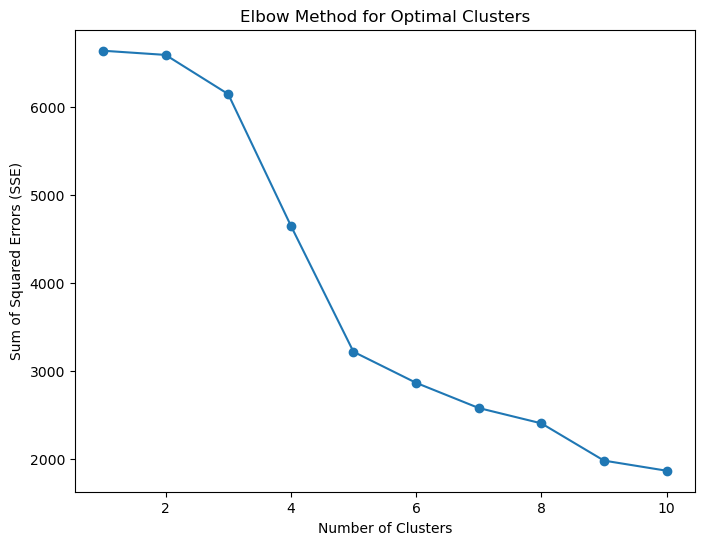

In [47]:
# 计算不同簇数的 SSE 并绘制肘部图
sse = []
cluster_range = range(1, 11)  # 尝试从1到10个簇

for n_clusters in cluster_range:
    # 使用手写层次聚类进行聚类
    model = AgglomerativeClustering_diy(n_clusters=n_clusters, linkage_method='complete', metric='manhattan')
    labels = model.fit_predict(train_df_scaled)
    model.labels_ = labels  # 将聚类结果存储到 model 中

    # 计算每个聚类数对应的 SSE
    sse_value = model.compute_sse(train_df_scaled)
    sse.append(sse_value)

# 绘制肘部图
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, sse, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.show()

### 绘制相似度矩阵

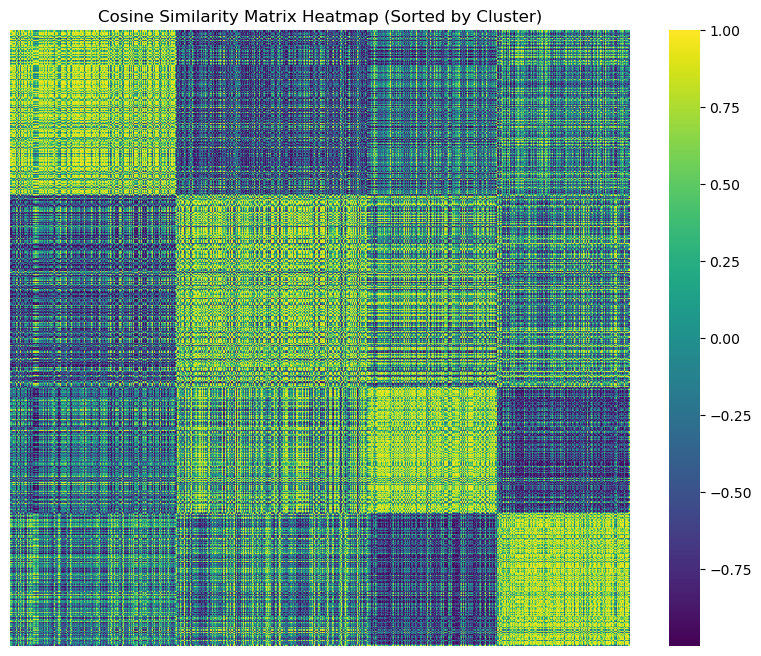

In [43]:
# 计算余弦相似度矩阵
similarity_matrix = cosine_similarity(train_df_scaled)

MyHC = AgglomerativeClustering_diy(n_clusters=5, linkage_method='complete', metric='manhattan')
MyHC.fit_predict(train_df_scaled)

# 获取聚类标签
labels = MyHC.labels_

# 根据聚类标签对数据进行排序
sorted_indices = np.argsort(labels)
sorted_similarity_matrix = similarity_matrix[sorted_indices, :][:, sorted_indices]

# 可视化排序后的相似矩阵
plt.figure(figsize=(10, 8))
sns.heatmap(sorted_similarity_matrix, cmap='viridis', xticklabels=False, yticklabels=False)
plt.title('Cosine Similarity Matrix Heatmap (Sorted by Cluster)')
plt.show()

### 在层次聚类中，`linkage_methods` 和 `affinity_methods` 分别控制 **簇间距离的计算方式** 和 **数据点之间的距离度量**。不同的组合对聚类的结果有显著影响。

---

### **1. `linkage_methods`（链接方法，簇间距离计算方式）**

这是用来确定如何计算簇与簇之间的距离的。常见的方法包括：

- **`ward`（沃德法）：**
    
    - 尝试最小化所有簇的总平方误差（SSE）。
    - 适用于数值型数据，通常可以生成紧密且均匀的簇。
    - **特点**：
        - 只支持 `euclidean`（欧几里得距离）。
        - 对距离变化较为敏感。
- **`complete`（全链接法）：**
    
    - 取两个簇之间所有点对的最大距离。
    - **特点**：
        - 产生较为紧密的簇。
        - 对噪声点和离群点敏感。
- **`average`（均值链接法）：**
    
    - 取两个簇之间所有点对的平均距离。
    - **特点**：
        - 生成相对平衡的簇，不像 `complete` 那么紧密，也不像 `single` 那么稀疏。
        - 不太受离群点影响。

---

### **2. `affinity_methods`（距离度量，数据点间的距离计算方式）**

这是用来定义样本点之间的距离度量的方式，也被称为 "metric"（度量）。

- **`euclidean`（欧几里得距离）：**
    
    - 计算两个点在多维空间中的直线距离。
    - 公式：$d(x, y) = \sqrt{\sum_{i=1}^{n} (x_i - y_i)^2}$
    - **特点**：
        - 最常用的距离度量。
        - 在数据标准化后效果更好。
- **`manhattan`（曼哈顿距离）：**
    
    - 计算两个点在各维度的绝对差的和，类似于网格城市中的“街区距离”。
    - 公式：$d(x, y) = \sum_{i=1}^{n} |x_i - y_i|$
    - **特点**：
        - 对高维数据中的噪声更鲁棒。
        - 不同尺度的数据需要标准化。
- **`cosine`（余弦距离）：**
    
    - 计算两个向量之间的余弦相似度，常用于文本和高维稀疏数据。
    - 公式（余弦相似度）：$\text{cosine}(x, y) = \frac{\sum_{i=1}^{n} x_i y_i}{\sqrt{\sum_{i=1}^{n} x_i^2} \cdot \sqrt{\sum_{i=1}^{n} y_i^2}}​​$ 
    - 余弦距离则为：$\text{cosine distance} = 1 - \text{cosine similarity}$
    - **特点**：
        - 忽略向量的绝对大小，仅关注方向。
        - 常用于文本聚类和自然语言处理场景。

---

### **3. 两者结合的意义**

不同的 `linkage_methods` 和 `affinity_methods` 组合用于控制层次聚类的行为：

- **`linkage_methods` 决定了簇间的关系如何度量**：
    - 是最小距离（单链）、最大距离（全链）还是平均距离。
- **`affinity_methods` 决定了数据点之间的关系如何计算**：
    - 是几何距离（欧几里得或曼哈顿）还是方向相似性（余弦）。

---

### **常见的组合**

1. `ward` + `euclidean`：
    
    - 只能与欧几里得距离搭配。
    - 在低维数值数据上效果通常较好。
    - 适合生成紧密的簇。
2. `complete` + `manhattan`：
    
    - 适合高维数据，且对噪声和离群点敏感。
    - 适合需要生成紧密簇的场景。
3. `average` + `cosine`：
    
    - 适合高维稀疏数据（如文本或文档）。
    - 对方向敏感，忽略数据的绝对大小。
4. `complete` + `euclidean`：
    
    - 在低维数值数据中，对离群点敏感。

---

### **选择方法的依据**

- **数据特性**：
    
    - 如果是数值型数据，优先选择 `ward` 和 `euclidean`。
    - 如果是高维稀疏数据（如文本），优先选择 `cosine`。
- **对离群点的敏感性**：
    
    - 如果希望减少离群点的影响，选择 `average`。
    - 如果离群点很重要，选择 `complete`。
- **聚类需求**：
    
    - 如果需要更紧密的簇，选择 `ward` 或 `complete`。
    - 如果需要平衡簇的大小，选择 `average`。

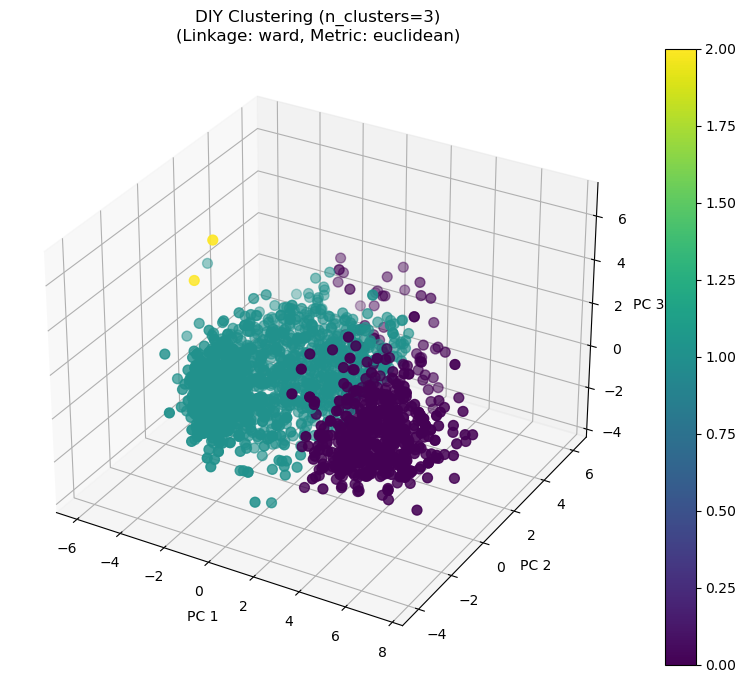

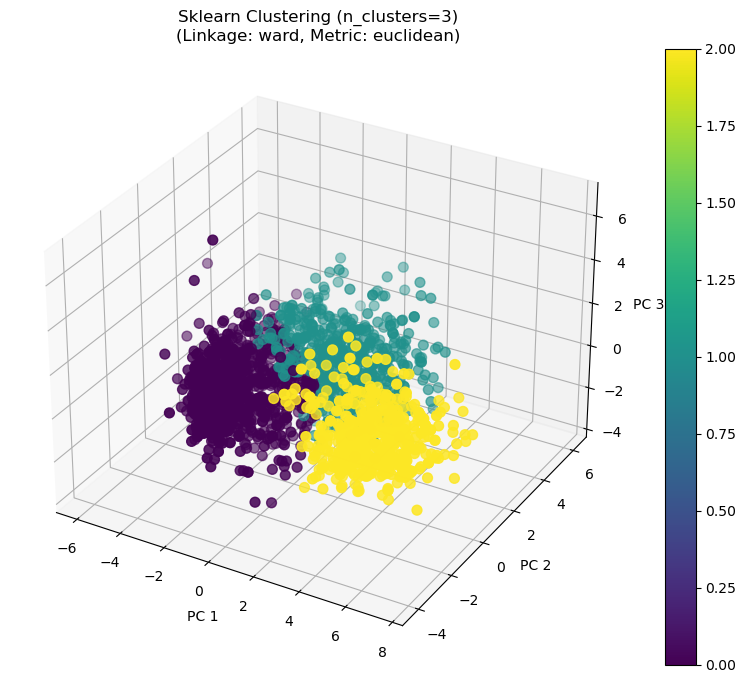

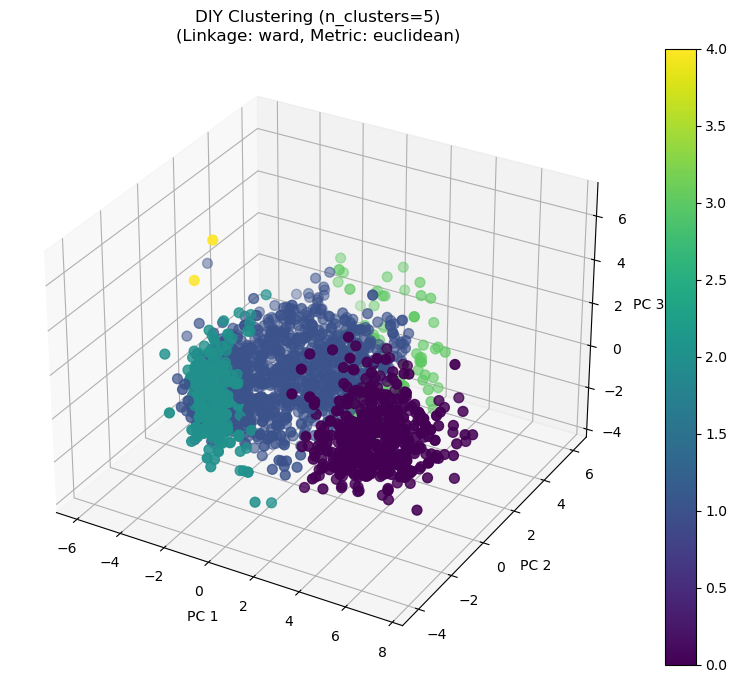

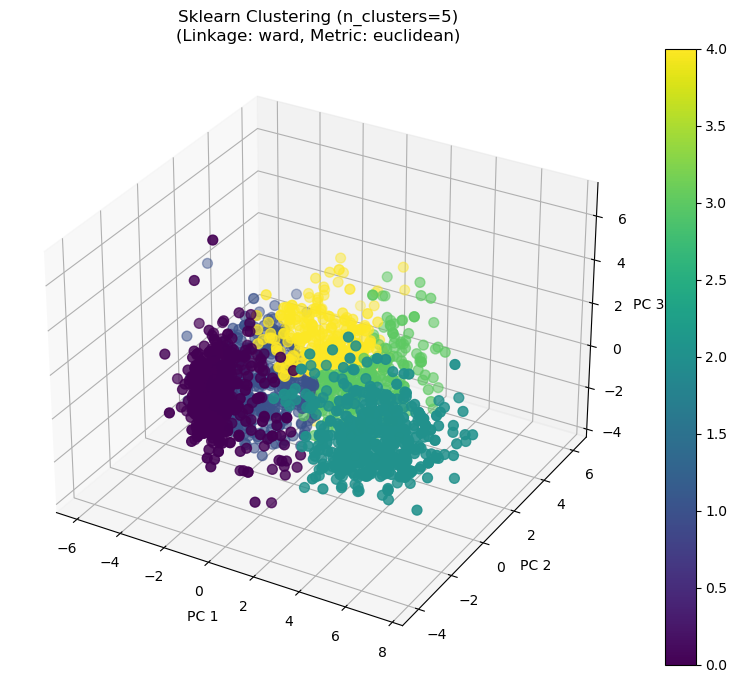

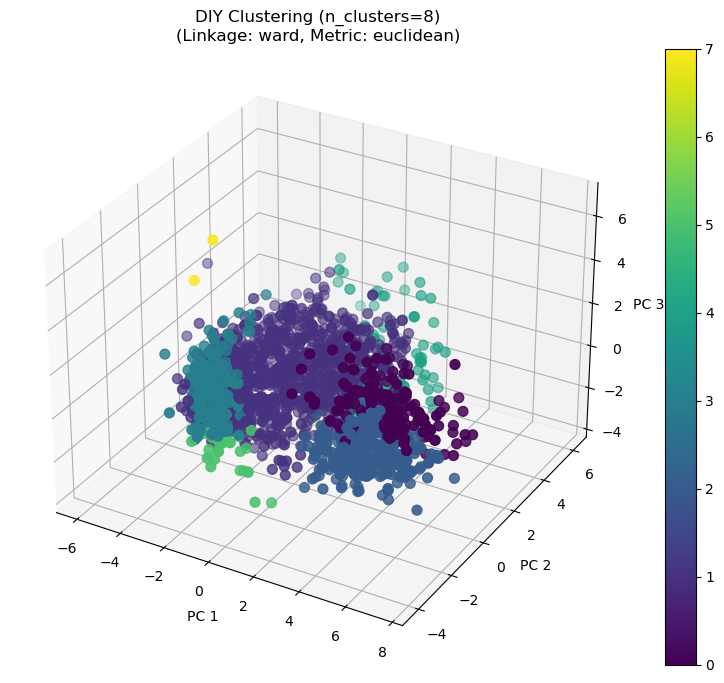

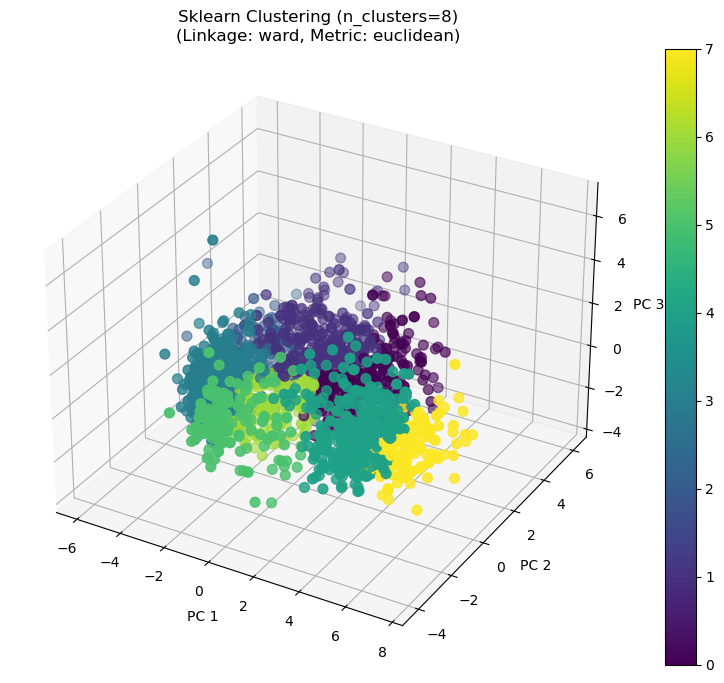

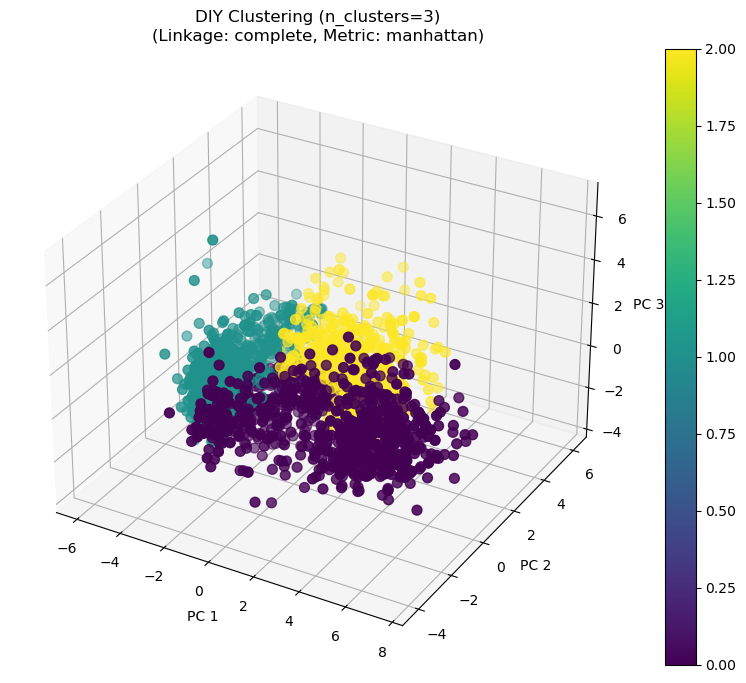

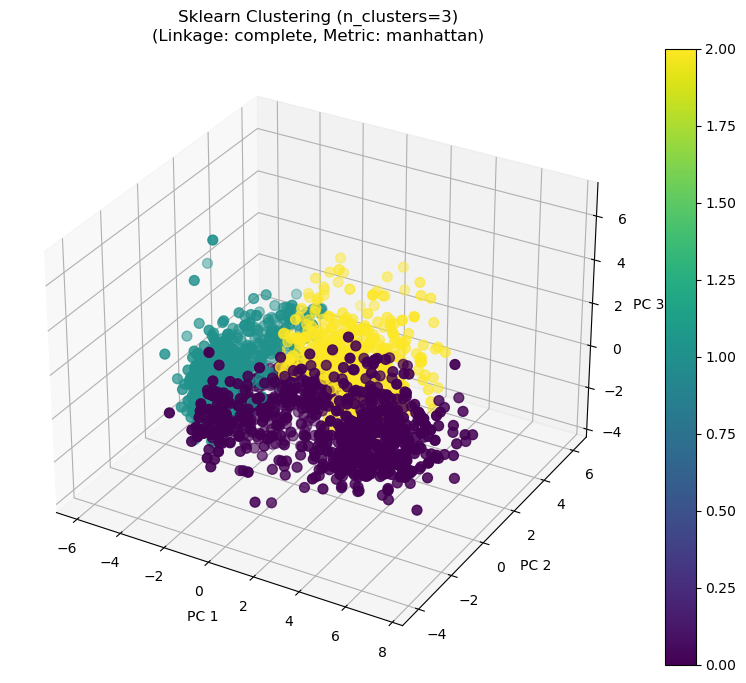

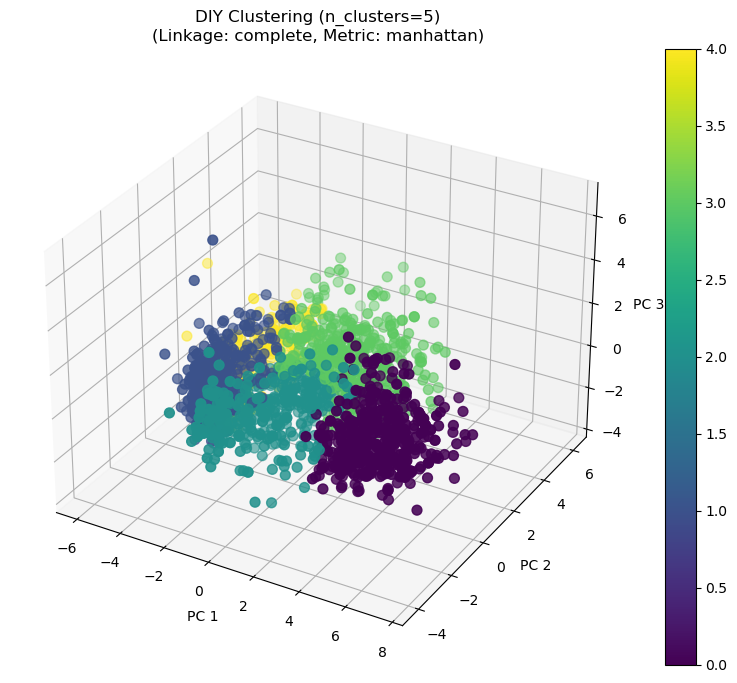

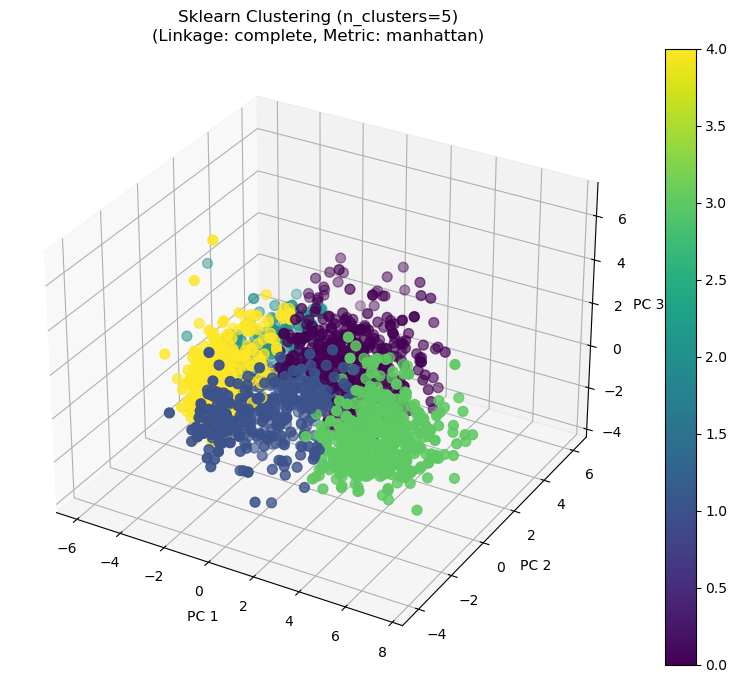

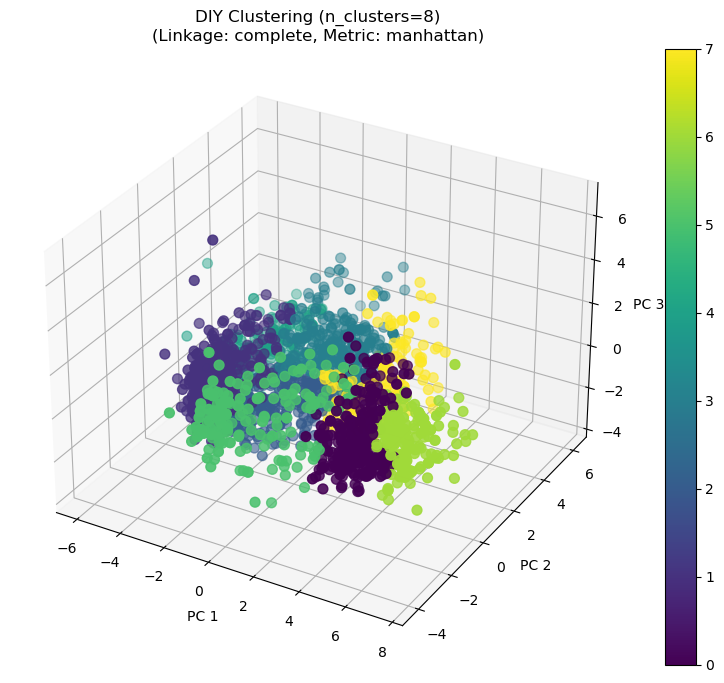

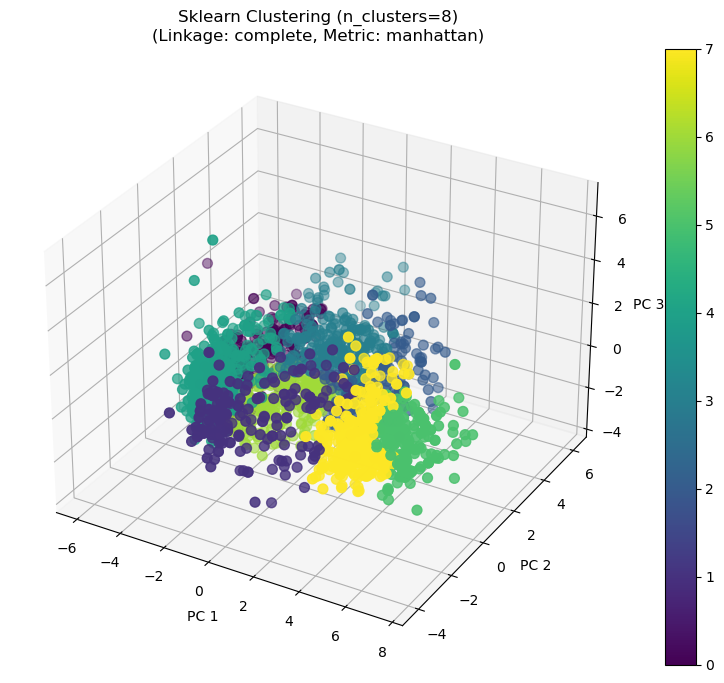

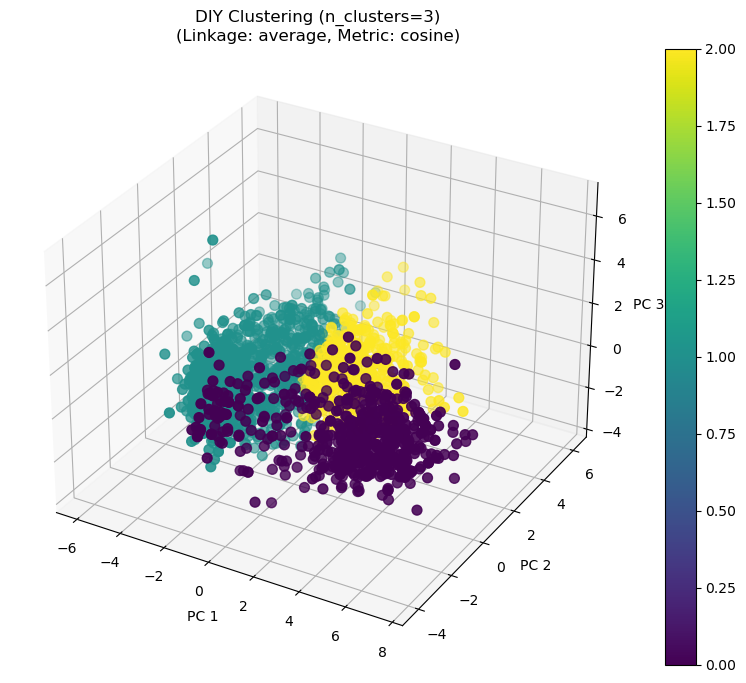

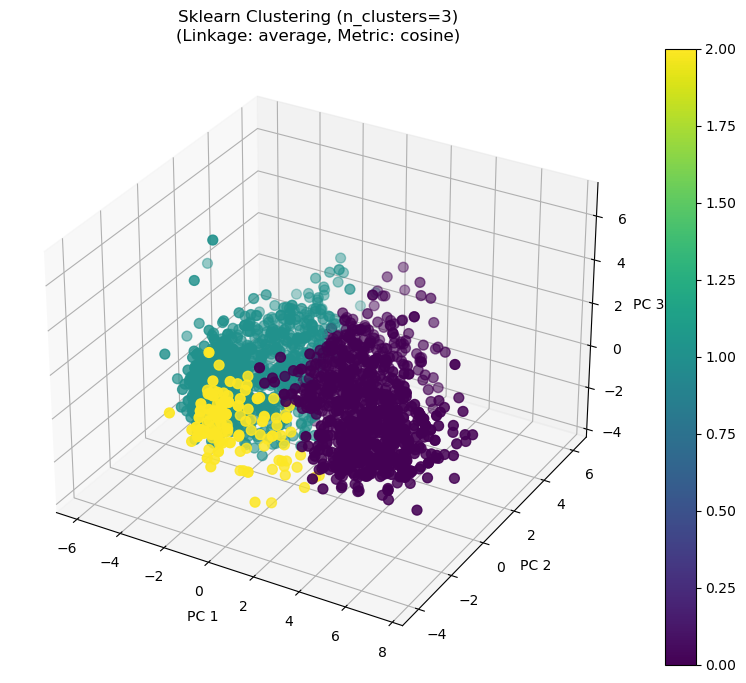

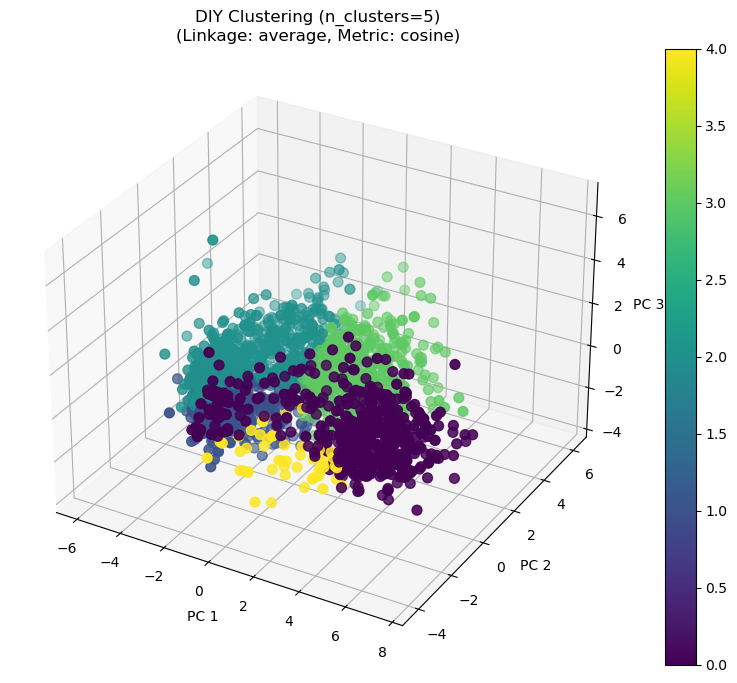

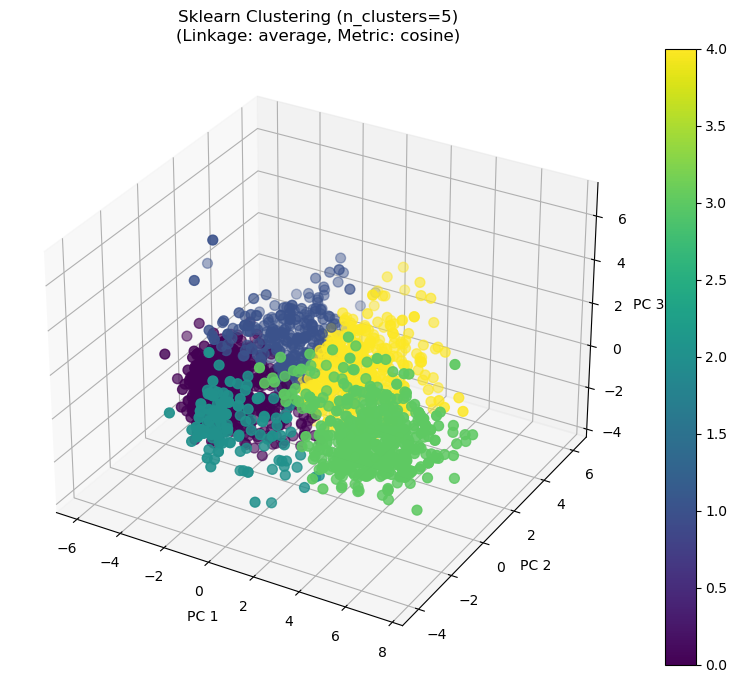

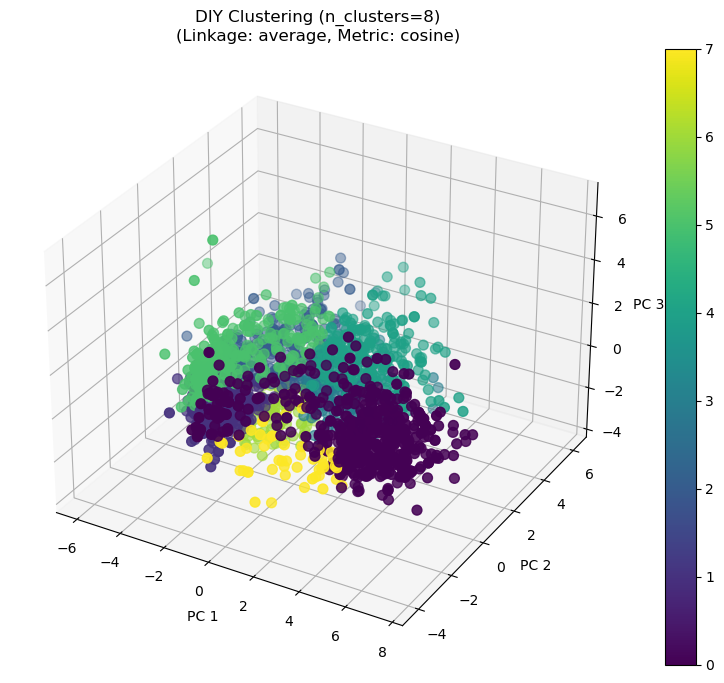

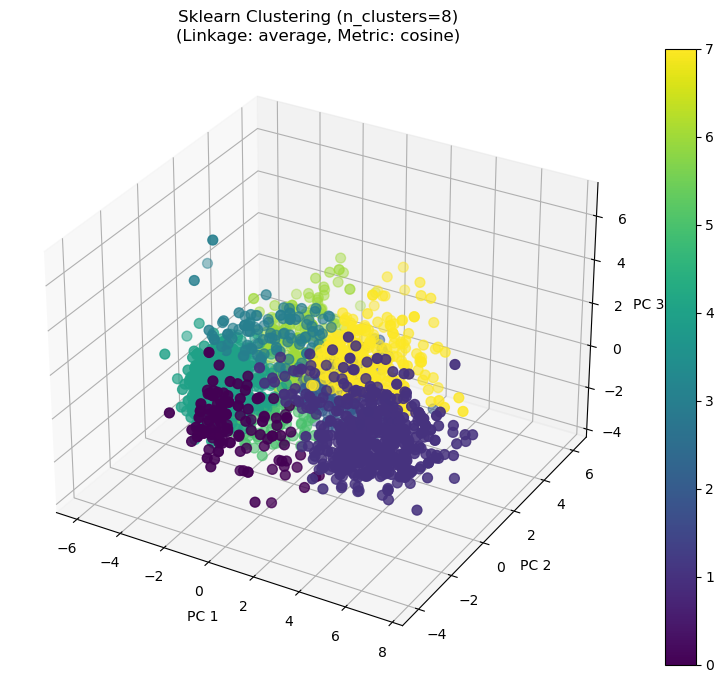

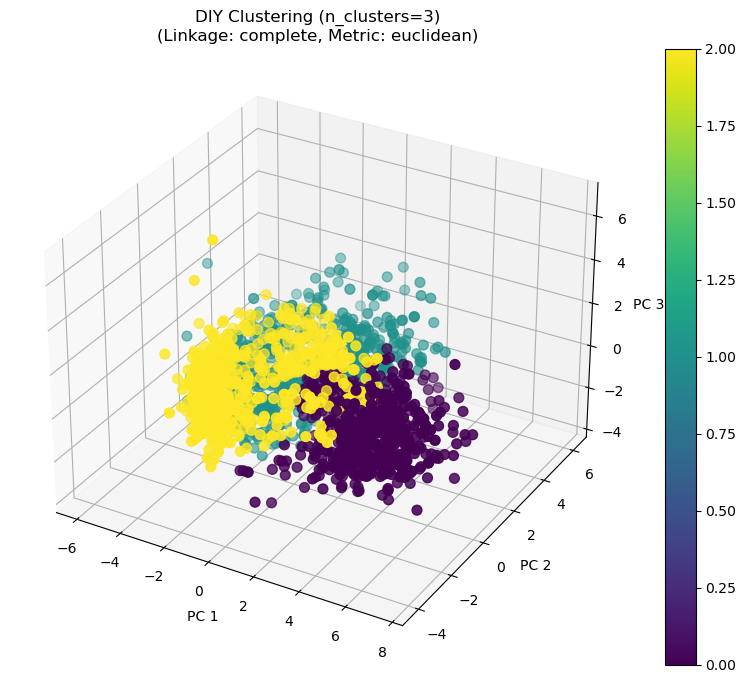

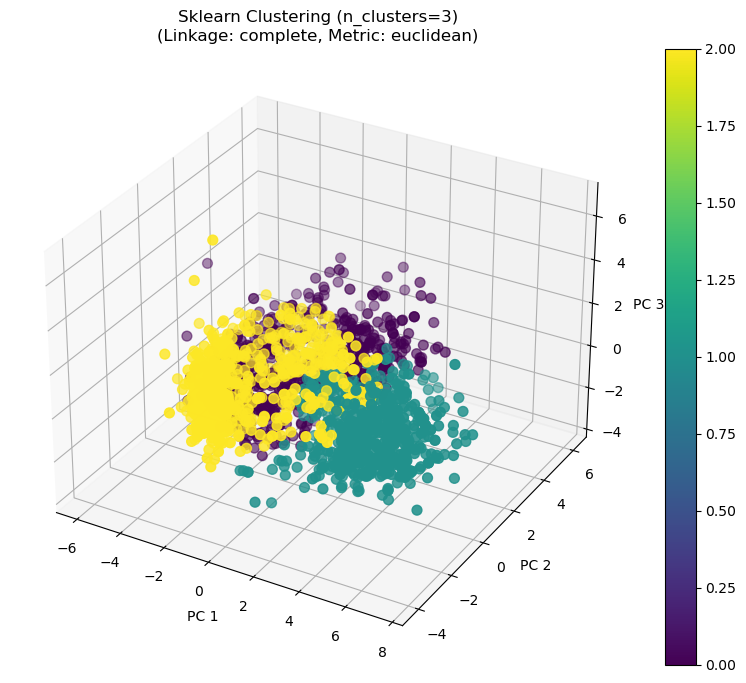

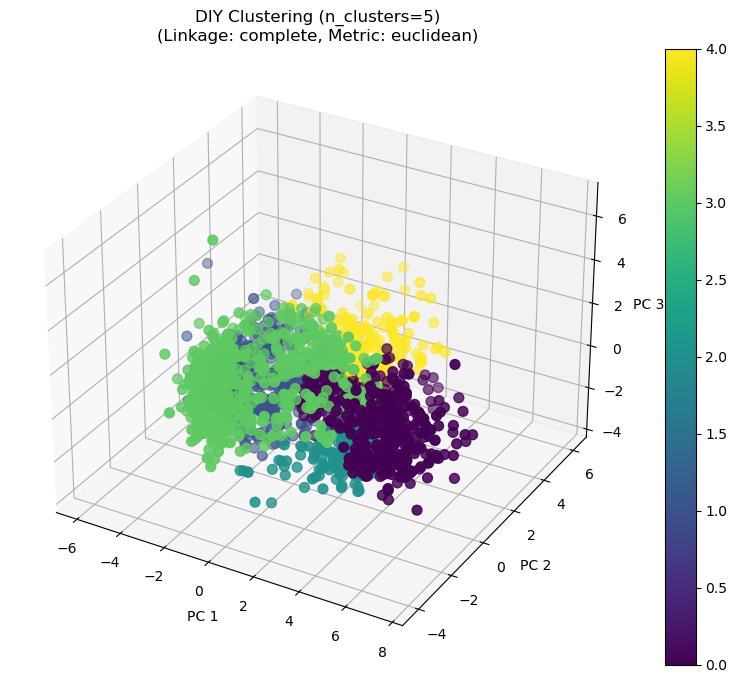

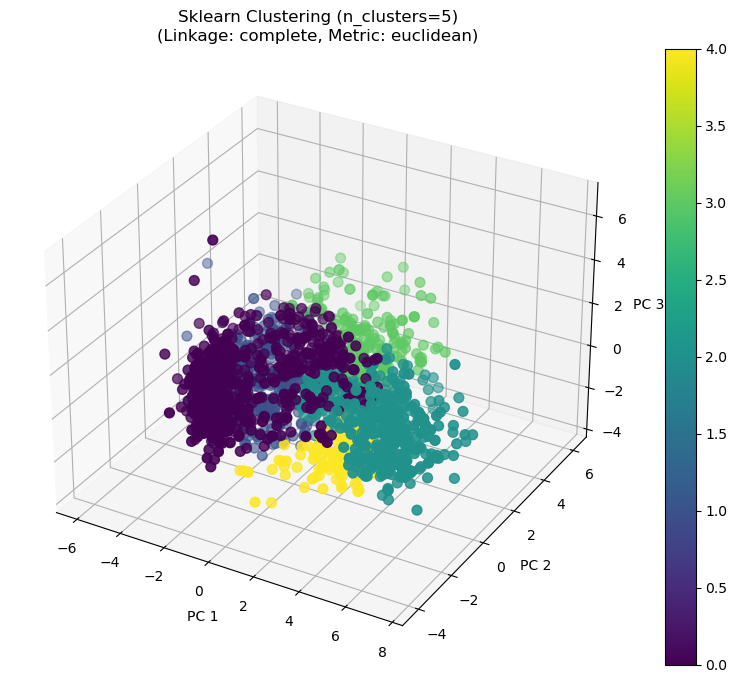

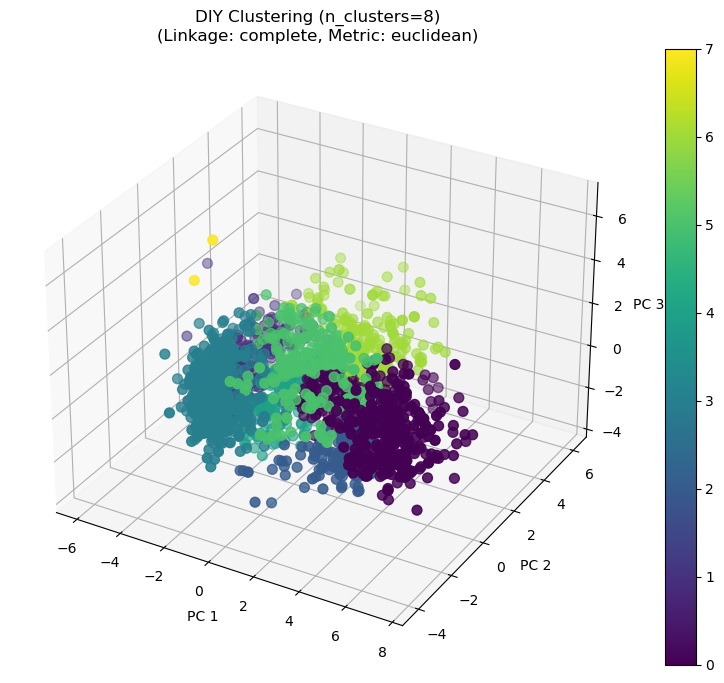

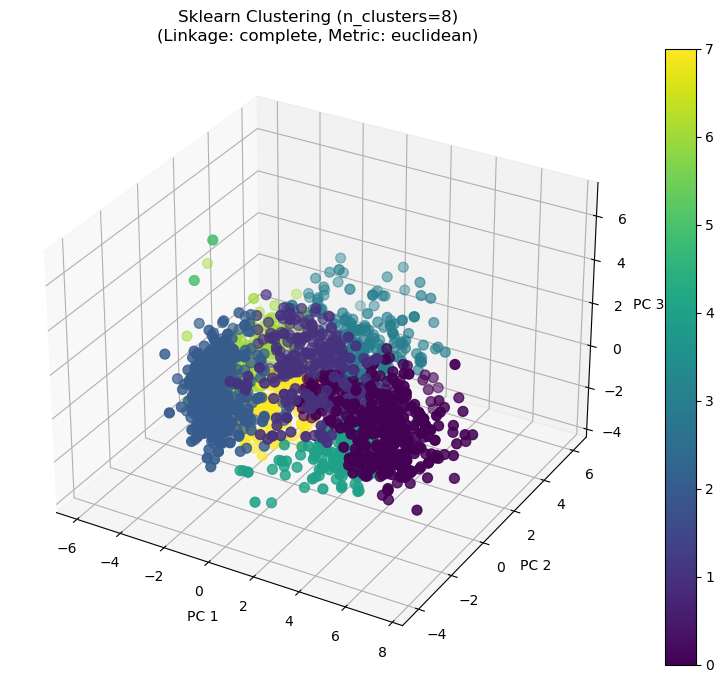

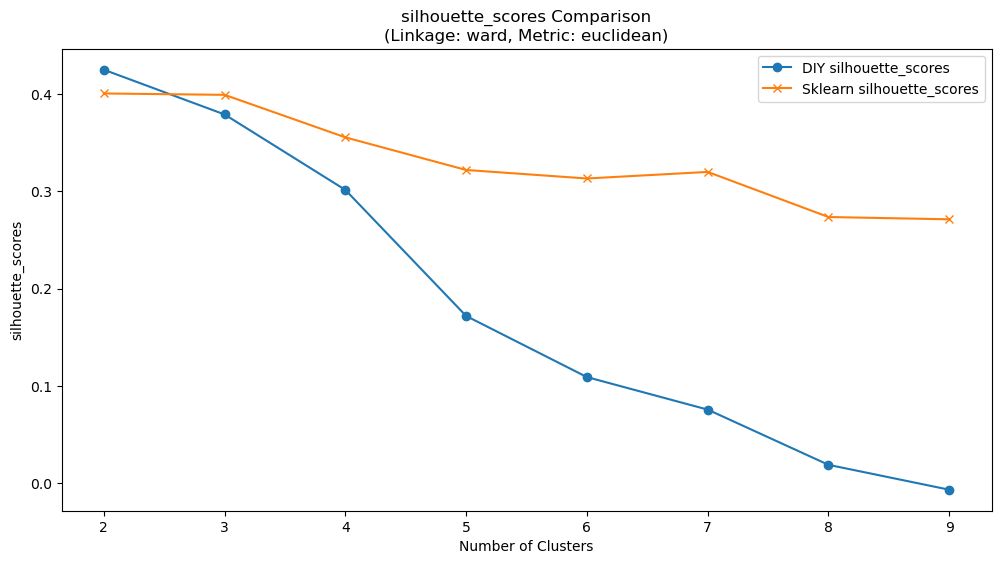

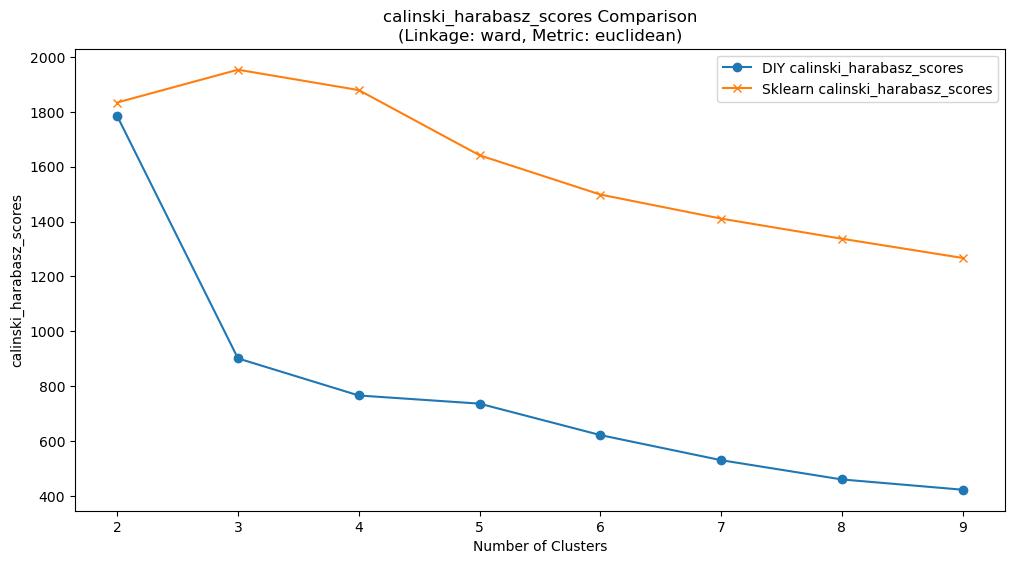

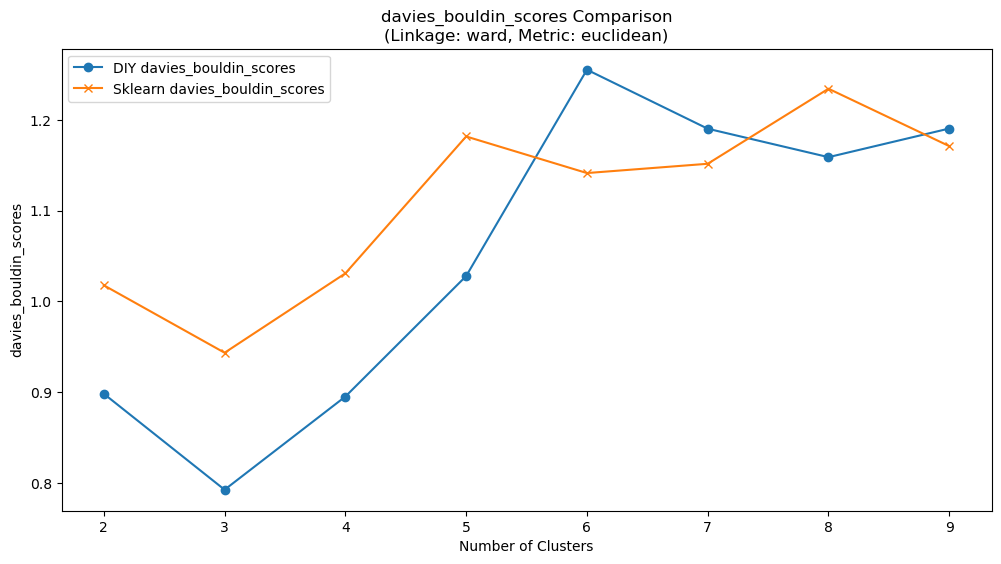

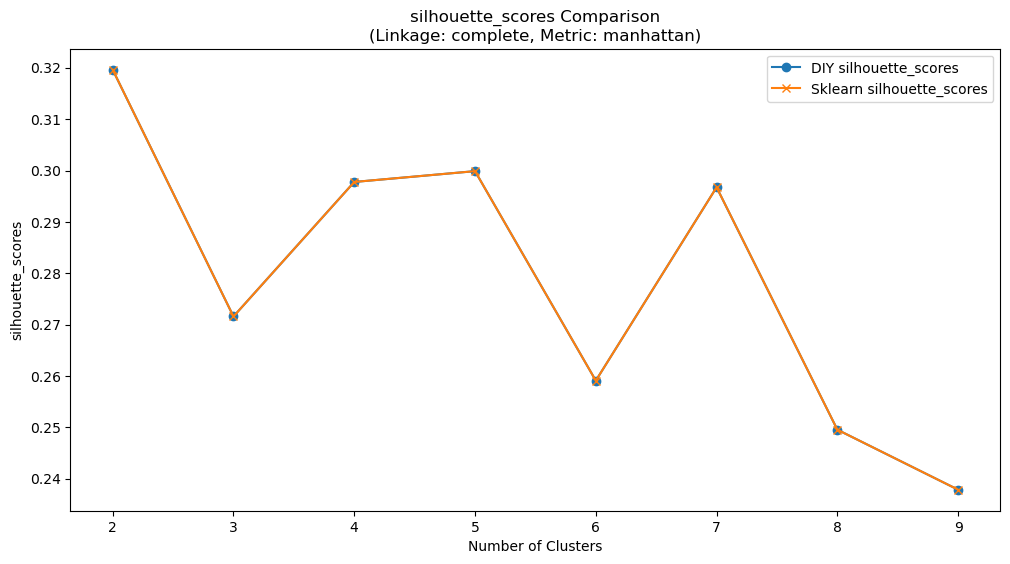

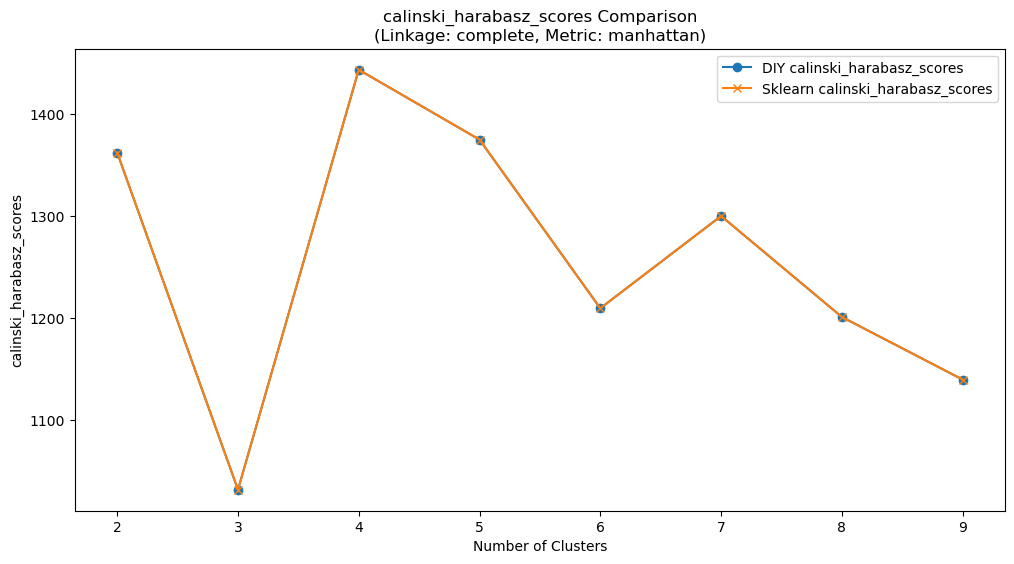

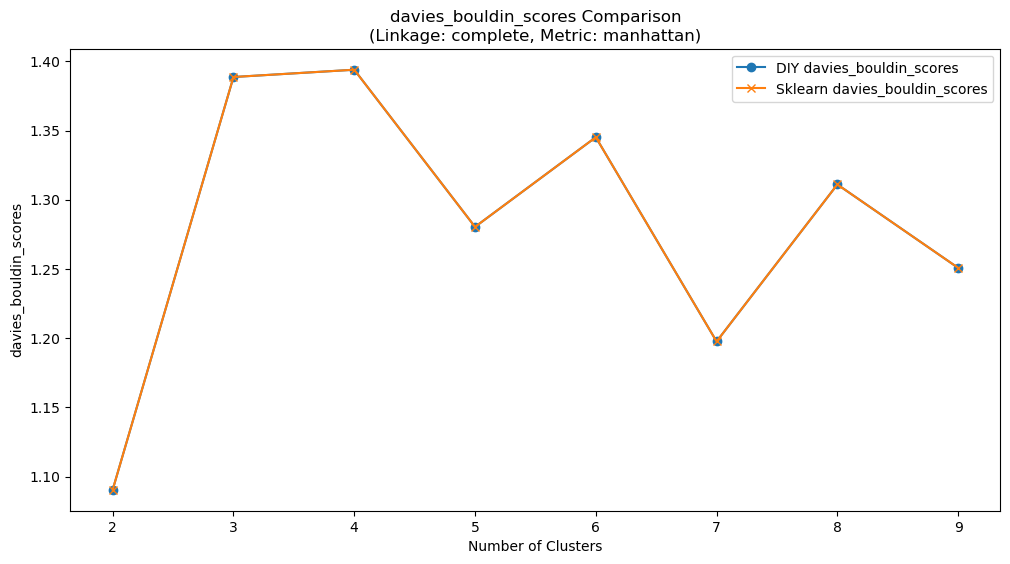

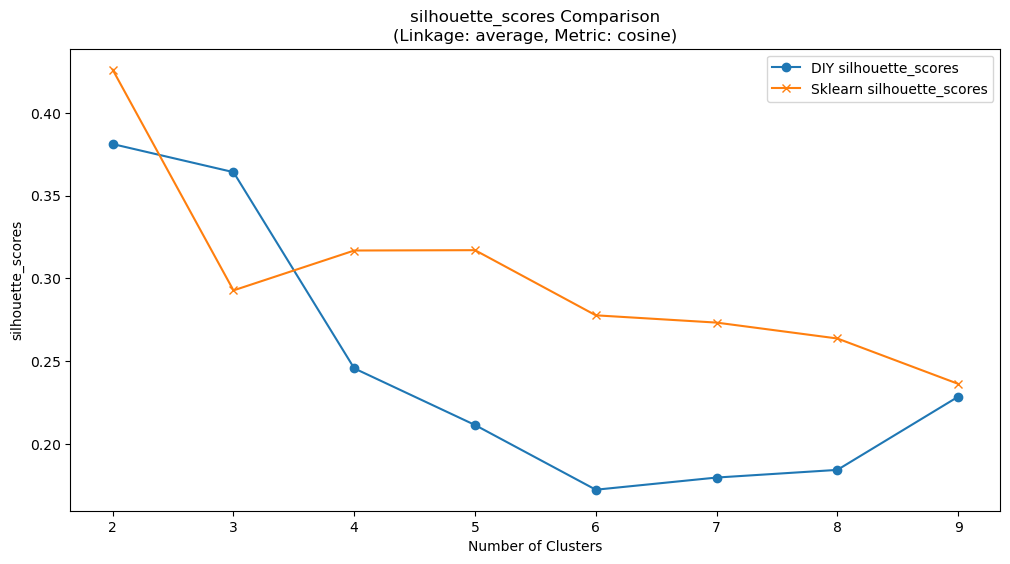

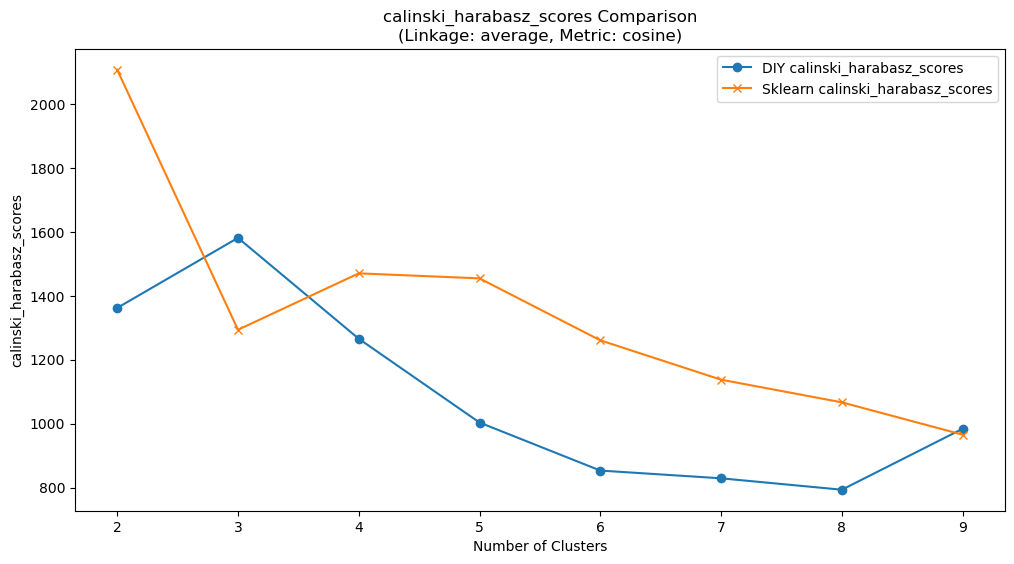

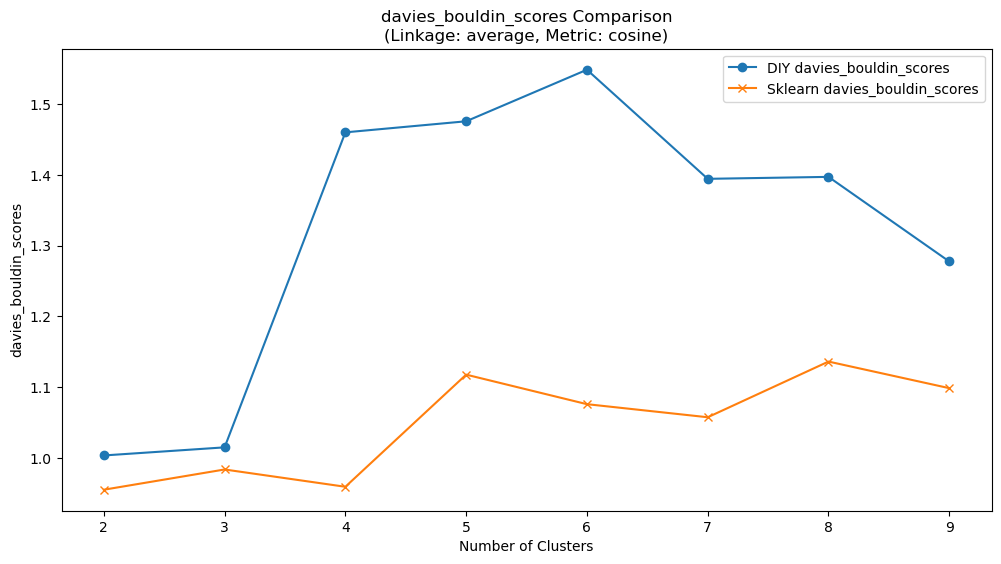

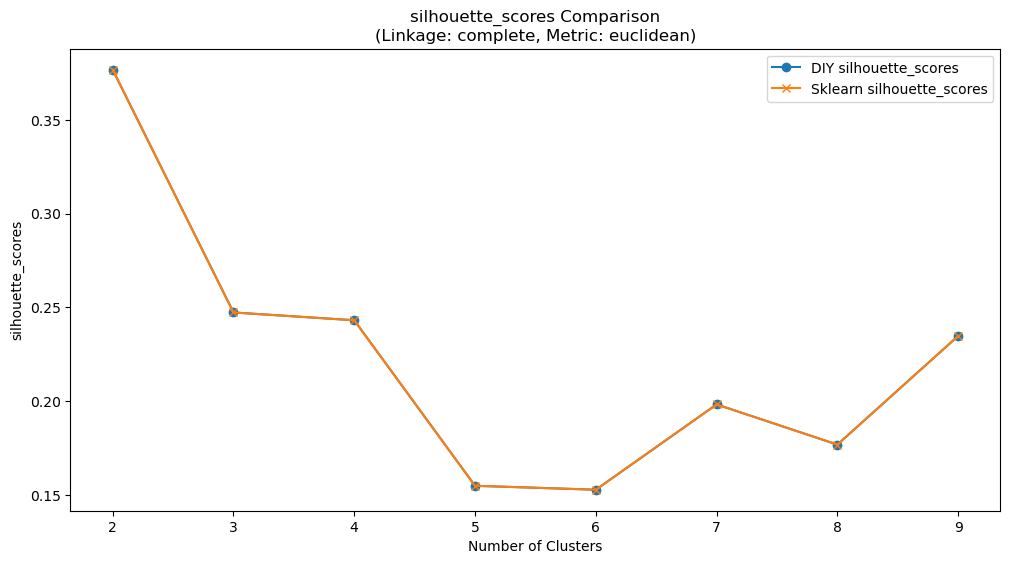

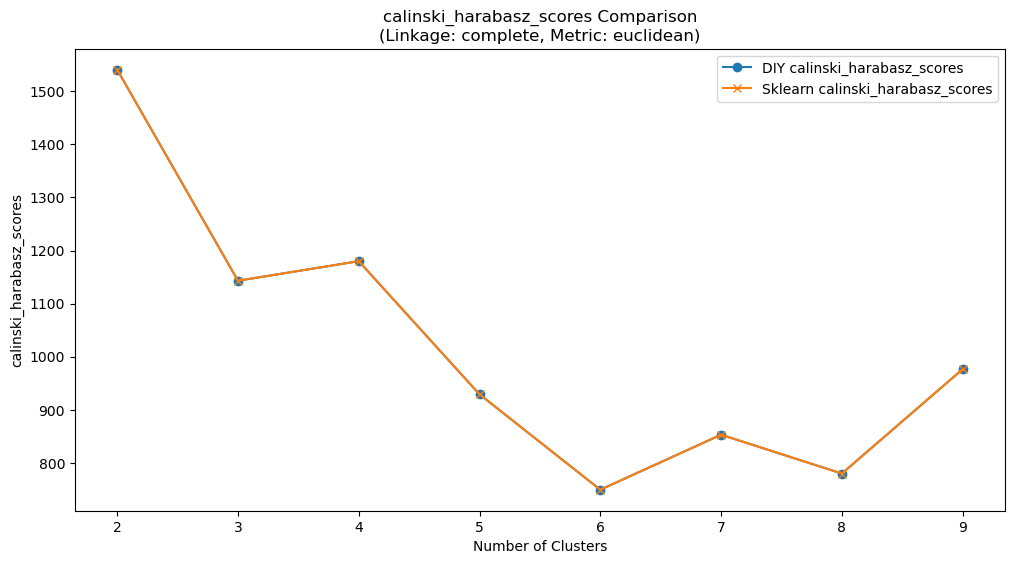

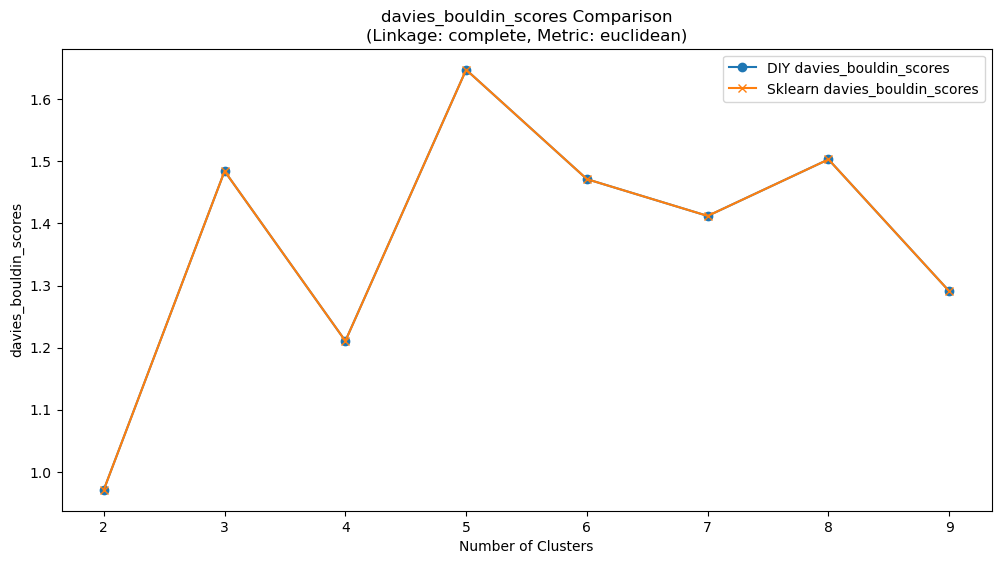

In [49]:
# 可视化3D聚类
def plot_3d_clusters(X, labels, title):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    unique_labels = np.unique(labels)
    normalized_labels = np.searchsorted(unique_labels, labels)
    scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=normalized_labels, cmap='viridis', s=50)
    ax.set_title(title)
    ax.set_xlabel("PC 1")
    ax.set_ylabel("PC 2")
    ax.set_zlabel("PC 3")
    plt.colorbar(scatter)
    plt.show()

# 参数设置
n_clusters_range = range(2, 10)

# 定义你需要的四种组合
combinations = [
    ("ward", "euclidean"),
    ("complete", "manhattan"),
    ("average", "cosine"),
    ("complete", "euclidean")
]

results = {
    "silhouette_scores": {"diy": [], "sklearn": []},
    "calinski_harabasz_scores": {"diy": [], "sklearn": []},
    "davies_bouldin_scores": {"diy": [], "sklearn": []}
}

for linkage_method, affinity_method in combinations:
    for n_clusters in n_clusters_range:
        # 手写实现
        agg_cluster_diy = AgglomerativeClustering_diy(
            n_clusters=n_clusters,
            linkage_method=linkage_method,
            metric=affinity_method
        )
        clusters_diy = agg_cluster_diy.fit_predict(train_df)

        # 使用库函数
        if affinity_method == 'cosine':
            cosine_distances = pairwise_distances(train_df, metric='cosine')
            agg_cluster_sklearn = AgglomerativeClustering(
                n_clusters=n_clusters,
                linkage=linkage_method,
                metric='precomputed'
            )
            clusters_sklearn = agg_cluster_sklearn.fit_predict(cosine_distances)
        else:
            agg_cluster_sklearn = AgglomerativeClustering(
                n_clusters=n_clusters,
                linkage=linkage_method,
                metric=affinity_method
            )
            clusters_sklearn = agg_cluster_sklearn.fit_predict(train_df)

        # 计算评估指标
        silhouette_avg_diy = silhouette_score(train_df, clusters_diy)
        calinski_diy = calinski_harabasz_score(train_df, clusters_diy)
        davies_diy = davies_bouldin_score(train_df, clusters_diy)

        silhouette_avg_sklearn = silhouette_score(train_df, clusters_sklearn)
        calinski_sklearn = calinski_harabasz_score(train_df, clusters_sklearn)
        davies_sklearn = davies_bouldin_score(train_df, clusters_sklearn)

        results["silhouette_scores"]["diy"].append(silhouette_avg_diy)
        results["silhouette_scores"]["sklearn"].append(silhouette_avg_sklearn)
        results["calinski_harabasz_scores"]["diy"].append(calinski_diy)
        results["calinski_harabasz_scores"]["sklearn"].append(calinski_sklearn)
        results["davies_bouldin_scores"]["diy"].append(davies_diy)
        results["davies_bouldin_scores"]["sklearn"].append(davies_sklearn)

        # 可视化3D聚类结果
        if n_clusters in [3, 5, 8]:
            plot_3d_clusters(
                train_df, clusters_diy,
                f'DIY Clustering (n_clusters={n_clusters})\n(Linkage: {linkage_method}, Metric: {affinity_method})'
            )
            plot_3d_clusters(
                train_df, clusters_sklearn,
                f'Sklearn Clustering (n_clusters={n_clusters})\n(Linkage: {linkage_method}, Metric: {affinity_method})'
            )

# 可视化评分对比
for linkage_method, affinity_method in combinations:
    for metric_name, scores in results.items():
        plt.figure(figsize=(12, 6))

        # 提取当前方法组合的数据
        diy_scores = scores["diy"][:len(n_clusters_range)]
        sklearn_scores = scores["sklearn"][:len(n_clusters_range)]

        # 绘制评分对比图
        plt.plot(n_clusters_range, diy_scores, marker='o', label=f'DIY {metric_name}')
        plt.plot(n_clusters_range, sklearn_scores, marker='x', label=f'Sklearn {metric_name}')

        # 更新图表标题和标签
        plt.title(f'{metric_name} Comparison\n(Linkage: {linkage_method}, Metric: {affinity_method})')
        plt.xlabel('Number of Clusters')
        plt.ylabel(metric_name)
        plt.legend()
        plt.show()

        # 移除已绘制的组合数据
        scores["diy"] = scores["diy"][len(n_clusters_range):]
        scores["sklearn"] = scores["sklearn"][len(n_clusters_range):]


### 参数选择与实验方法
簇数（n_clusters）：在手写实现的层次聚类中，簇数 n_clusters 是一个关键参数。簇数的选择直接影响聚类效果，过多的簇可能会导致过拟合，而过少的簇则可能无法有效地分离数据。

### 肘部图分析方法：
通过计算不同簇数下的 SSE（Sum of Squared Errors）值，观察其变化趋势。

在肘部图中，拐点（肘部点）表示 SSE 增长速度发生显著变化的参数值，此点通常被认为是最佳簇数。
### 实验结果与趋势分析
在实验中，我们计算了从 1 到 10 个簇时的 SSE 值，并绘制了肘部图，观察了 SSE 随着簇数变化的趋势。

	簇数较小时（如 n_clusters < 5），SSE 值变化较为平缓，表示簇的紧凑性较高，聚类效果较为稳定。

	簇数接近 5 时，SSE 的增长速度开始加快，表明簇与簇之间的分离性降低。此时，簇的分布逐渐趋于平衡，且聚类质量较好。

	簇数大于 5 时，SSE 的增长速度明显提升，表明簇的分离性显著下降，多个簇合并为较大的簇，聚类效果明显变差。

### 肘部点判断
在肘部图中，肘部点对应于 SSE 曲线的拐点，是选择最佳簇数的关键参考。

从肘部图来看，最佳簇数约为 5。此时：

当簇数小于 5 时，SSE 的增长较慢，簇的紧凑性较高，聚类效果稳定。

当簇数大于 5 时，SSE 的增长加速，聚类效果下降，簇间分离性减弱。

综上所述，n_clusters=5 被认为是本实验中最优的簇数。

### 数据相似性矩阵分析
为了进一步分析层次聚类的效果，我们通过相似性矩阵的热力图来展示聚类结果。在热力图中，横轴和纵轴表示数据点，数据点按照聚类标签排序，颜色反映了数据点间的相似度。

### 热力图分析：
从热力图中，我们可以清晰地看到 5 个簇的结构，其中每个簇的数据点在图中表现为紧密的黄色区域，显示出较高的相似性。

簇与簇之间的区域呈现较深的蓝色或绿色，表明不同簇之间的相似度较低，分离性较好。

该热力图表明，手写实现的层次聚类在簇间具有明显的分离性，同时簇内紧凑，表现出良好的聚类效果。

### 相似性矩阵的特点：
每个簇内的点相似度较高，颜色较浅（接近黄色），簇间的点相似度较低，颜色较深（接近蓝色），显示出较强的分离性。

观察到簇内的紧凑性较好，且簇之间的分离度较大，验证了手写层次聚类在此数据集上的有效性。

通过这种分析方法，我们不仅能够直观地观察到聚类结果的质量，还能够进一步确认选择的最佳簇数对聚类效果的优化作用。
